# Part 2 : Recommendation sytem based on user informations

To do this notebook I used information in that great article :  
https://towardsdatascience.com/user-user-collaborative-filtering-for-jokes-recommendation-b6b1e4ec8642  

I adapt the concept for my own purpose, I apply it to personnal informations in order to find similarities between customer.  

We will focus on this part on comparing user between user and see if correlation exist in order to recommand effective retail object.

# The summary of the notebook is written below

I. Import useful library and python file containing our functions  

II. Create the dataframe  

* A. Merge Customers and Transactions
* B. Selecting informations
* C. Cleaning data
* D. Modifying data to numerical
* E. Grouping customers
* F. Standardization  

III. Relation between customer  

* A. Relation between 20 first customers
* B. Relation for one specific customer
* C. Selecting closest neighbours   

IV. Prediction on items  

V. Final Part : Doing prediction by combining Part III. and Part IV.  

* A. Retrieving all df we need 
* B. Easy way to have prediction on an index or cust_id 
* C. Creation of a metrics 



# I. Import useful library and python file containing our functions

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import statistics
import Function_02 as f2

# set the graphs to show in the jupyter notebook
%matplotlib inline

# II. Create the dataframe

## A. Merge Customers and Transactions

We only need customer and transactions and we will merge them.

In [2]:
Customers = pd.read_csv("Customer.csv")
Transaction = pd.read_csv("Transactions.csv")
#this df below is just the list of usefull cust_id for our study
List_unique_cust_id = pd.read_csv("list_cust_id.csv")

We only keep customer id that we select from previous notebook

In [3]:
print('shape of customer with all customers :', Customers.shape)
Customers = Customers[Customers.customer_Id.isin(List_unique_cust_id['unique_cust_id'].tolist())]
print('shape of customer with only needed customers :', Customers.shape)

shape of customer with all customers : (5647, 4)
shape of customer with only needed customers : (4031, 4)


In [4]:
Customers.head(3)

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
2,268159,08-01-1970,F,8.0
3,270181,10-01-1970,F,2.0


In [5]:
Merge_cust_trans = pd.merge(left = Transaction,
                         right = Customers,
                         left_on = "cust_id",
                         right_on = "customer_Id",
                         how = "left")
Merge_cust_trans.head(2)

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,customer_Id,DOB,Gender,city_code
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,270351.0,26-09-1981,M,5.0
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,270384.0,11-05-1973,F,8.0


## B. Selecting informations

For this notebook, we will only used personal information on people and about their transaction. So we will keep :
* unique cust_id
* The number of mouth their transation were done
* Store_type in which they used to buy their object 
* Date of Birth
* Gender
* city_code

In [6]:
df = Merge_cust_trans[['cust_id', 'tran_date', 'Store_type', 'DOB', 'Gender', 'city_code']].copy()
df.head(2)

,cust_id,tran_date,Store_type,DOB,Gender,city_code
0,270351,28-02-2014,e-Shop,26-09-1981,M,5.0
1,270384,27-02-2014,e-Shop,11-05-1973,F,8.0


## C. Cleaning data

* Removing some missing informations in the table

In [7]:
print(df.isnull().sum())
print('\n Processing... \n')
df_non_null = f2.remove_null_value(df)
df_non_null.isnull().sum()

cust_id          0
tran_date        0
Store_type       0
DOB           2711
Gender        2720
city_code     2717
dtype: int64

 Processing... 



cust_id       0
tran_date     0
Store_type    0
DOB           0
Gender        0
city_code     0
dtype: int64

We don't have some information here, and it's because we don't take the full cust_id, we only select those with more than 3 items.  
So, we droped those rows.

In [8]:
df_non_null.head(2)

,cust_id,tran_date,Store_type,DOB,Gender,city_code
0,270351,28-02-2014,e-Shop,26-09-1981,M,5.0
1,270384,27-02-2014,e-Shop,11-05-1973,F,8.0


## D. Modifying data to numerical

Here, we apply a function which do a lot of modification.

* We convert the tran_date to the number of mounth till the buy
* We convert the gender to 0 (male) and 1(female)
* We convert the DOB to the age when the person buy it
* We also change the store type to a number {e-shop: 0, Teleshop: 1, MBR: 2, Flagship store: 3}

We drop unsunsed column

In [9]:
df_numerical = f2.modification_on_table(df_non_null)
df_numerical.head()

,cust_id,mouth_till_purchase,store_id,age_when_purchase,gender_id,city_code
0,270351,84,0,32,0,5.0
1,270384,84,0,41,1,8.0
2,273420,84,1,21,0,8.0
3,271509,84,0,33,0,3.0
4,273420,84,1,21,0,8.0


## E. Grouping customers

So we can see that we have several line in this df corresponding to the same cust_id

In [10]:
df_numerical.cust_id.value_counts()

268819    13
269449    13
266794    12
269245    12
268663    12
          ..
272153     3
271032     3
273287     3
268975     3
268935     3
Name: cust_id, Length: 4028, dtype: int64

So, now we need to do a group by cust_id and take the mean value and we obtain a data frame with no duplicate cust_id

In [11]:
df_grouped = df_numerical.groupby(by=["cust_id"]).mean()
df_non_stand = df_grouped.reset_index()
df_non_stand.to_csv('non_stand_user_perso_info.csv', index=False)
df_grouped.head(2)

,mouth_till_purchase,store_id,age_when_purchase,gender_id,city_code
cust_id,,,,,
266783,103.8,0.200000,38.200000,0.0,4.0
266784,101.0,1.333333,20.666667,1.0,10.0


## F. Standardization

In [12]:
df_stand = f2.standardize(df_grouped)
df_stand.to_hdf('standadize_df_user_personal_info.hdf', 'standadize_df_user_personal_info')
df_stand.head(2)

,mouth_till_purchase,store_id,age_when_purchase,gender_id,city_code
cust_id,,,,,
266783,0.527619,0.066667,0.776923,0.0,0.333333
266784,0.447619,0.444444,0.102564,1.0,1.000000


We check if there is no duplicate

In [13]:
print(f'They are {df_stand.duplicated().sum()} duplicates rows')

They are 0 duplicates rows


Now we have our data frame with all personal informations about needed customers

# III. Relation between customer

Now we will start to compare customer to see how much they are related

We will focus this study on few info : 
* The city code assuming when number are close to each other, cities will be near too geographically speaking
* The average age of the customer when he bought items
* The number of mouth till the purchase was done
* The store id, it's where the customer used to buy more
* The gender 1 for a female and 0 for a male

## A. Relation between 20 first customers

For the moment I restrain the number of customer to 20 because it's a very long to calculate the full set of customer with theirs similarities.  
We will only do this calculus for display some visualization

In [14]:
df_restrain = df_stand.iloc[:20,:]
print(f'they are in total {len(df_stand)} differents customers')

they are in total 4028 differents customers


In [15]:
size = len(df_restrain)
sim_mat = np.array([f2.similarity_pearson(df_restrain.iloc[i,:], df_restrain.iloc[j,:]) for i in range(0,size) for j in range(0,size)])
sim_df = pd.DataFrame(data = sim_mat.reshape(size, size))
sim_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,-0.676006,-0.669193,0.068848,0.196130,-0.193139,-0.720305,0.291593,-0.369056,-0.077255,-0.637886,-0.006758,0.936461,-0.339489,-0.180266,0.264540,-0.414145,-0.044954,0.194949,0.197046
1,-0.676006,1.000000,0.293799,-0.245884,0.398939,-0.092176,0.994233,-0.342007,0.154976,0.261548,0.939060,0.036590,-0.565637,0.474272,0.164005,-0.201740,0.325582,-0.083167,0.365043,-0.658422
2,-0.669193,0.293799,1.000000,0.645993,0.000019,0.364133,0.295425,-0.393791,0.906475,0.668356,0.346884,0.548913,-0.887177,0.732353,0.796780,-0.837275,0.681771,-0.364846,-0.018528,-0.385247
3,0.068848,-0.245884,0.645993,1.000000,0.366235,0.603961,-0.260550,-0.540724,0.887182,0.792911,-0.026724,0.905478,-0.264045,0.731662,0.893823,-0.888815,0.726003,-0.777538,0.372595,-0.430279
4,0.196130,0.398939,0.000019,0.366235,1.000000,0.316933,0.368155,-0.682050,0.320196,0.611722,0.585010,0.674302,0.110276,0.680320,0.483057,-0.466083,0.565830,-0.775622,0.994364,-0.893386


Here it's the same table, but with a heatmap

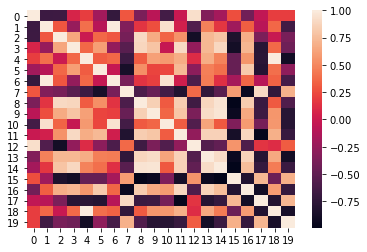

In [16]:
sns.heatmap(sim_df.iloc[:20,:20])

When the cell is whiter, it's mean those two variables are highly correlated

## B. Relation for one specific customer

Let's here focus our result with one specific customer.  
We don't have to calculate all the matrix, because it's very very long.   
We will only calculate pearson correlation for the person we need but with all other customers.

We choose here which customer we want to focus on.  
We can choose it by an index or by his customer_id

In [17]:
index = False
cust_id = 266784
customer_index, customer_id = f2.select_customer(index , cust_id, df_non_stand  )

In [18]:
#We take back the full data frame
df_restrain = df_stand.copy()
size = len(df_restrain)
sim_mat = np.array([f2.similarity_pearson(df_restrain.iloc[customer_index,:], df_restrain.iloc[j,:])for j in range(0,size)])
sim_df = pd.DataFrame(data = sim_mat.reshape(1, size))
sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4018,4019,4020,4021,4022,4023,4024,4025,4026,4027
0,-0.676006,1.0,0.293799,-0.245884,0.398939,-0.092176,0.994233,-0.342007,0.154976,0.261548,...,-0.372318,-0.088148,-0.773179,0.520926,-0.837151,-0.18475,-0.54424,-0.121226,0.525545,-0.417316


We now have the pearson correlation between our specific customer and all the other

## C. Selecting closest neighbours

We can specify a treshold, here we can take 0.9.  
This treshold will allow us to select only customers with higher correlation

In [19]:
threshold = 0.99
list_of_neighbours = f2.find_neighbours(sim_df.iloc[0], threshold)
print(f'This is the list of neighbours for {customer_id} with a threshold of {threshold} : \n\n{list_of_neighbours}')

This is the list of neighbours for 266784 with a threshold of 0.99 : 

[1, 6, 85, 118, 169, 420, 488, 737, 835, 915, 1055, 1433, 1447, 2587, 3052, 3911, 3957, 3975]


We can have access to all info from customer in this list, we display here information before the standardization

In [20]:
neighbour_info = f2.give_info_neighbours(df_non_stand, sim_df, list_of_neighbours)
neighbour_info.head()

,cust_id,mouth_till_purchase,store_id,age_when_purchase,gender_id,city_code,pearson_similarity
1,266784,101.00,1.333333,20.666667,1.0,10.0,1.000000
420,267700,106.20,1.800000,26.200000,1.0,10.0,0.999329
85,266987,102.40,1.400000,20.600000,1.0,10.0,0.998933
488,267836,102.50,1.250000,19.750000,1.0,10.0,0.997387
3911,275040,101.75,1.125000,20.500000,1.0,10.0,0.996448


Now that we have so correlation between customer, we can try to predict item according to this information

# IV. Prediction on items

Now we will use the neighbour list to make prediction of item the specific customer have seen or have not seen yet.

We retrieve our user_item matrix with only customer that we are interested in

In [21]:
Product_mapped = pd.read_csv("product_info_mapped.csv")
user_item_matrix = pd.read_hdf("user_item_matrix.hdf","user_item_matrix")
user_item_matrix.head()

object_id,1_1,1_3,1_4,2_1,2_3,2_4,3_10,3_4,3_5,3_8,...,5_10,5_11,5_12,5_3,5_6,5_7,6_10,6_11,6_12,6_2
cust_id,,,,,,,,,,,,,,,,,,,,,
266783,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
266785,0.0,0.0,0.0,4.0,0.0,3.5,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
266788,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
266794,0.0,3.5,0.0,0.0,2.5,0.0,1.5,0.0,0.0,4.0,...,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
list_similar_user_indices = neighbour_info['cust_id'].tolist()
print(list_similar_user_indices)
#we select max_neighbours which is the number of max neighbours we take into account for the prediction
max_neighbours = 10

[266784, 267700, 266987, 267836, 275040, 269790, 267058, 267173, 266806, 269830, 275131, 273226, 275162, 269026, 272245, 268393, 268751, 268597]


In [31]:
reco_unknown = f2.recommend_item_for_all(list_similar_user_indices[0], list_similar_user_indices[1:5],max_neighbours, user_item_matrix,Product_mapped, known= False, items=23)
reco_unknown

,object_name,object_id,mean_from_similar_user
16,Books_Children,5_11,5.00
21,Home and kitchen_Bath,6_11,5.00
8,Electronics_Personal Appliances,3_8,4.50
5,Footwear_Kids,2_4,4.00
10,Electronics_Audio and video,3_10,3.25
0,Clothing_Mens,1_4,3.00
20,Home and kitchen_Kitchen,6_10,3.00
4,Footwear_Women,2_3,3.00
19,Home and kitchen_Furnishing,6_2,2.75
9,Electronics_Cameras,3_9,2.50


In [24]:
reco_known = f2.recommend_item_for_all(list_similar_user_indices[0], list_similar_user_indices[1:5], max_neighbours, user_item_matrix,Product_mapped, known= True, items=10)
reco_known

,object_name,mean_from_similar_user,real_rank_from_266784
0,Electronics_Mobiles,0.0,2.0
1,Books_Fiction,0.0,5.0
2,Books_Non-Fiction,0.0,3.0


In [25]:
mse, rmse = f2.meatrics_mse_rmse(reco_known)
print('mse:', mse)
print('rmse:', rmse)

mse: 12.666666666666666
rmse: 3.559026084010437


# V. Final Part : Doing prediction by combining Part III. and Part IV. 

## A. Retrieving all df we need 

In [26]:
df_stand = pd.read_hdf('standadize_df_user_personal_info.hdf','standadize_df_user_personal_info')
df_non_stand = pd.read_csv('non_stand_user_perso_info.csv')
Product_mapped = pd.read_csv("product_info_mapped.csv")
user_item_matrix = pd.read_hdf("user_item_matrix.hdf","user_item_matrix")
user_item_matrix.head()

object_id,1_1,1_3,1_4,2_1,2_3,2_4,3_10,3_4,3_5,3_8,...,5_10,5_11,5_12,5_3,5_6,5_7,6_10,6_11,6_12,6_2
cust_id,,,,,,,,,,,,,,,,,,,,,
266783,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
266785,0.0,0.0,0.0,4.0,0.0,3.5,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
266788,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
266794,0.0,3.5,0.0,0.0,2.5,0.0,1.5,0.0,0.0,4.0,...,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## B. Easy way to have prediction on an index or cust_id 

In [27]:
index = False
cust_id = 266784
threshold = 0.99
customer_index, customer_id = f2.select_customer(index , cust_id, df_non_stand)
unknown, known = f2.do_prediction(customer_index, customer_id, max_neighbours, threshold,df_stand,df_non_stand,Product_mapped,user_item_matrix)

print('\n')
mse, rmse = f2.meatrics_mse_rmse(known)
print('mse:', mse)
print('rmse:', rmse)

This is the len of the list of neighbours for 266784 with a threshold of 0.99 : 

18 with a restriction at 10 



mse: 3.0
rmse: 1.7320508075688772


## C. Creation of a metrics 

In [35]:
index = 3
cust_id = False
threshold = 0.98
max_neighbours = 10

RMSE = []
MSE = []
def find_metrics(index):
    customer_index, customer_id = f2.select_customer(index , cust_id, df_non_stand)
    _, known = f2.do_prediction(customer_index, customer_id, max_neighbours, threshold,df_stand,df_non_stand,Product_mapped,user_item_matrix)
    mse, rmse = f2.meatrics_mse_rmse(known)
    MSE.append(mse)
    RMSE.append(rmse)
    
for i in range(100):
    find_metrics(i)

This is the len of the list of neighbours for 266783 with a threshold of 0.98 : 

21 with a restriction at 10 

This is the len of the list of neighbours for 266784 with a threshold of 0.98 : 

34 with a restriction at 10 

This is the len of the list of neighbours for 266785 with a threshold of 0.98 : 

37 with a restriction at 10 

This is the len of the list of neighbours for 266788 with a threshold of 0.98 : 

42 with a restriction at 10 

This is the len of the list of neighbours for 266794 with a threshold of 0.98 : 

33 with a restriction at 10 

This is the len of the list of neighbours for 266799 with a threshold of 0.98 : 

2 with a restriction at 10 

This is the len of the list of neighbours for 266806 with a threshold of 0.98 : 

38 with a restriction at 10 

This is the len of the list of neighbours for 266807 with a threshold of 0.98 : 

19 with a restriction at 10 

This is the len of the list of neighbours for 266809 with a threshold of 0.98 : 

38 with a restriction a

In [36]:
print('mean mse:', statistics.mean(MSE))
print('mean rmse:', statistics.mean(RMSE))

mean mse: 4.546877831790123
mean rmse: 2.0056898975415773


So, the RMSE score tends towerd 2.00 meanning that would mean the estimated ratings on average are about 2.00 higher or lower than the actual ratings.  
Here, our scale is from 0 to 5, so it's is not a very good result at all.

# Thank you for reading all this part 2 now let's move to the third part